In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from scipy.optimize import minimize
import scipy.constants as const

In [2]:
#function takes in a cubic np density array and rolls it so tha the highest point is in the center.
#only to be used for the steady state images

def rho_roll(rho):
    rho_len = rho.shape[0]
    # finding the maximum value's index
    max_ind = np.where(rho == np.amax(rho))
    x_max = max_ind[0][0]
    y_max = max_ind[1][0]
    z_max = max_ind[2][0]
    signed_x_dist_to_cent = int(rho_len / 2) - x_max
    signed_y_dist_to_cent = int(rho_len / 2) - y_max
    signed_z_dist_to_cent = int(rho_len / 2) - z_max
    #moving the core to the center of the cube
    rho_n = np.roll(rho, signed_x_dist_to_cent, axis=0)
    rho_n2 = np.roll(rho_n, signed_y_dist_to_cent, axis=1)
    rho_n3 = np.roll(rho_n2, signed_z_dist_to_cent, axis=2)
    rho = rho_n3
    return rho

In [3]:
# function that calculates distances between two 3d points:

def get_distance(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2]- b[2])**2)

In [4]:
#cuts off a distance array such that it only has elements < a certain length

def dist_cutoff(dist, dist_lim):
    distance = []
    for x in dist:
        if (x < dist_lim):
            distance.append(x)
    return np.asarray(distance)

In [5]:
#cuts off a density array at a given number of elements
#not in place

def dens_cutoff(dens, n_elements):
    densities = np.zeros(n_elements)
    for i in range(0, n_elements):
        densities[i] = dens[i]
    return densities

In [6]:
#functions
def i1(arg):
    return np.tanh(arg/4)

def i2(arg):
    return np.tanh(arg) 

def i3(arg):
    return (np.tanh(np.sqrt(arg)))**2

def beta(f , rc):
    f = f * 1e15
    hbar = const.hbar
    c = const.c
    G = const.G
    GeV_to_J = 1.60218e-10
    prefactor = 6.9e-9 * (rc ** (-2))
    factor = (hbar * (c**5)) / (32 * G * f**2) 
    return prefactor*factor / ((GeV_to_J)**2)

#testing
f1 = 1 
rc = 0.18
print(beta(f1 , rc))

0.9919857693768901


In [11]:
#analytic profile of the core

def an_prof(r, rc, f):
    b = beta(f, rc)
    rho = ((1.9*10**7) / (rc**4)) #*((1/0.1)**2)
    i1term = 1. + 2.6*i1(b)
    exp_inner = 2. - ((1./5.) * i2(b))
    exp_outer = -8. + ((22./5.)*i3(b))
    term = (1 + i1term*0.091*(r*np.sqrt(1 + b)/rc)**exp_inner)**exp_outer
    #print("i1 term for f = " + str(f) + ": " + str(i1term))
    #print("Inner Exponent for f = " + str(f) + ": " + str(exp_inner))
    #print("Outer Exponent for f = " + str(f) + ": " + str(exp_outer))
    #print('\n')
    return rho * term

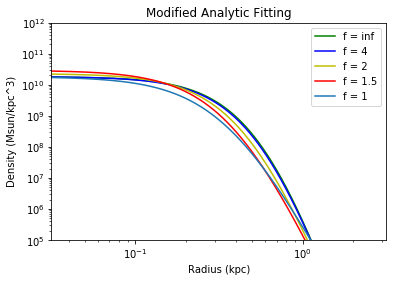

In [12]:
#testing

radius = np.logspace(-2, 1, 10000)
den1 = an_prof(radius, 0.18, np.inf)
den2 = an_prof(radius, 0.18, 4)
den3 = an_prof(radius, 0.17, 2)
den4 = an_prof(radius, 0.16, 1.5)
den5 = an_prof(radius, 0.18, 1.)

plt.plot(radius, den1, 'g')
plt.plot(radius, den2, 'b')
plt.plot(radius, den3, 'y')
plt.plot(radius, den4, 'r')
plt.plot(radius, den5)

plt.xscale('log')
plt.yscale('log')
plt.ylim(10**5, 10**(12))
plt.xlim(10**(-1.5), 10**(0.5))
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (Msun/kpc^3)')
plt.title('Modified Analytic Fitting')
plt.legend(['f = inf', 'f = 4', 'f = 2', 'f = 1.5', 'f = 1'])

In [13]:
#X2 function

def X2_fun(rc, f, dist, dens, dist_lim):
    r = dist_cutoff(dist, dist_lim)
    densities = dens_cutoff(dens, len(r))
    X2 = (((an_prof(r, rc, f)) - densities)**2)
    indices = [0, len(X2)-1]
    return X2[indices].sum()

/home/mnotis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/home/mnotis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/home/mnotis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/home/mnotis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


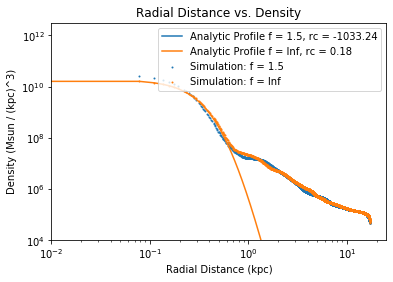

In [31]:
#radial-density fitting function
#params are two nparrays
#analytic radial profile function

def fit_profile(f, dist, dens, dist_lim):
    dist1 = np.sort(dist)
    dens1 = (-1)*(np.sort(dens*(-1)))
    params = (f, dist1, dens1, dist_lim)
    x0 = np.asarray(1)
    result = minimize(X2_fun, x0, args = params)
    return result


path15 ='/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.5L20T4n400r256/radial0400.h5'
#path2 ='/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r256/radial0400.h5'
pathInf ='/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256/rad_filesradial0400.h5'

hf15 = h5py.File(path15, 'r')
#hf2 = h5py.File(path2, 'r')
hfInf = h5py.File(pathInf, 'r')

dist15 = np.array(hf15['distances'])
dens15 = np.array(hf15['densities'])

#dist2 = np.array(hf2['distances'])
#dens2 = np.array(hf2['densities'])

distInf = np.array(hfInf['distances'])
densInf = np.array(hfInf['densities'])

test_result15 = fit_profile(1.5, dist15, dens15, 1)
#test_result2 = fit_profile(2, dist2, dens2, 1)
test_resultInf = fit_profile(np.Inf, distInf, densInf, 1)

#testing
rc15 = test_result15.x[0]
#rc2 = test_result2.x[0]
rcInf = test_resultInf.x[0]

dist_lim = 0.65

plt.scatter(dist15, dens15, s = 1)
#plt.scatter(dist2, dens2, s = 1)
plt.scatter(distInf, densInf, s = 1)

plt.plot(r, an_prof(r, rc15, 1.5))
#plt.plot(r, an_prof(r, rc15, 2))
plt.plot(r, an_prof(r, rcInf, np.Inf))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(12.5))
plt.xlim(10**(-2), 10**(1.4))
textstr = 'rc = ' + "%.2f" % rc
plt.legend(['Analytic Profile f = 1.5, rc = ' + "%.2f" % rc15, 'Analytic Profile f = Inf, rc = ' + "%.2f" % rcInf, 'Simulation: f = 1.5', 'Simulation: f = Inf'])
#plt.legend(['Analytic Profile f = 1.5, rc = ' + "%.2f" % rc15, 'Analytic Profile f = 2, rc = ' + "%.2f" % rc2, 'Analytic Profile f = Inf, rc = ' + "%.2f" % rcInf, 'Simulation: f = 1.5', 'Simulation: f = 2', 'Simulation: f = Inf'])
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/fit_test.png', dpi = 200)